In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置微软雅黑/黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示异常
import warnings
warnings.filterwarnings('ignore')

In [12]:
# 1. Load data
df = pd.read_excel('情绪指标回测数据3.xlsx', parse_dates=['Date'])

In [54]:
# M = df['总得分'].loc[:'2024-12-31'].mean()
M = 0
SD = df['总得分'].loc[:'2024-12-31'].std()

In [61]:
SD=1

In [48]:
# 取数据
x = df['总得分'].loc[:'2024-12-31']

# 设定中心点（你这里设为0，如果想用均值可改成 x.mean() 或 x.median()）
M =0
# 向上 std（大于中心点的数据）
SD_up = x[x > M].std(ddof=0)   # ddof=0 表示总体std，和numpy默认一致
# 向下 std（小于中心点的数据）
SD_down = x[x < M].std(ddof=0)

In [62]:
raw_signal = []
prev = 0
for score in df['总得分']:
    if score >= M + 2*SD:
        sig = 2
    elif score >= M + SD:
        sig = 2 if prev == 2 else 1
    elif score >= M:
        sig = prev if prev in (2, 1) else 0
    elif score <= M - 2*SD:
        sig = -2
    elif score <= M - SD:
        sig = -2 if prev == -2 else -1
    else:
        sig = prev if prev in (-2, -1) else 0
    raw_signal.append(sig)
    prev = sig

df['RawSignal'] = raw_signal

In [49]:
raw_signal = []
prev = 0
for score in df['总得分']:
    if score >= M + 2*SD_up:
        sig = 2
    elif score >= M + SD_up:
        sig = 2 if prev == 2 else 1
    elif score >= M:
        sig = prev if prev in (2, 1) else 0
    elif score <= M - SD_down:
        sig = -2
    elif score <= M - SD_down:
        sig = -2 if prev == -2 else -1
    else:
        sig = prev if prev in (-2, -1) else 0
    raw_signal.append(sig)
    prev = sig

df['RawSignal'] = raw_signal

In [63]:
# 3. Apply 2‑day same‑signal confirmation filter
confirmed = []
prev_pos = 0  # initial portfolio position
for i in range(len(df)):
    if i == 0:
        confirmed.append(prev_pos)
        continue
    # need current raw signal equals previous raw signal to change
    if df.loc[i, 'RawSignal'] == df.loc[i-1, 'RawSignal'] and df.loc[i, 'RawSignal'] != prev_pos:
        prev_pos = df.loc[i, 'RawSignal']
    confirmed.append(prev_pos)

df['Signal_sentiment'] = confirmed

In [64]:
# Map Signal to Position percentages
df['Position'] = df['Signal_sentiment'].map({
    2: 0.8,   # 80%
    1: 0.65,  # 65%
    0: 0.5,   # 50%
    -1: 0.35, # 35%
    -2: 0.2   # 20%
})

In [65]:
# 4. Compute returns
df['ret'] = df['上证指数T+1收益率'] / 100
df['strat_ret'] = df['Position'] * df['ret']
df['bench_ret'] = 0.5 * df['ret']
df['excess_ret'] = df['strat_ret'] - df['bench_ret']
df['strat_nav'] = (1 + df['strat_ret']).cumprod()
df['bench_nav'] = (1 + df['bench_ret']).cumprod()
df['excess_nav'] = (1 + df['excess_ret']).cumprod()

In [66]:
# 5. Performance metrics helper
def calc_metrics(nav, ret):
    total = nav.iloc[-1] - 1
    days = len(nav)
    ann = nav.iloc[-1] ** (252 / days) - 1
    vol = ret.std(ddof=0) * np.sqrt(252)
    sharpe = (ann - 0.02) / vol if vol != 0 else np.nan
    mdd = (nav / nav.cummax() - 1).min()
    return total, ann, vol, sharpe, mdd

s_total, s_ann, s_vol, s_sharpe, s_mdd = calc_metrics(df['strat_nav'], df['strat_ret'])
b_total, b_ann, b_vol, b_sharpe, b_mdd = calc_metrics(df['bench_nav'], df['bench_ret'])

perf = pd.DataFrame({
    'Strategy (2‑day confirm)': [s_total, s_ann, s_vol, s_sharpe, s_mdd],
    'Benchmark (50%)': [b_total, b_ann, b_vol, b_sharpe, b_mdd]
}, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe (rf=2%)', 'Max Drawdown'])
perf

,Strategy (2‑day confirm),Benchmark (50%)
Total Return,0.577193,0.258789
Annualized Return,0.074066,0.036750
Annualized Volatility,0.097412,0.085405
Sharpe (rf=2%),0.555030,0.196124
Max Drawdown,-0.157252,-0.141715


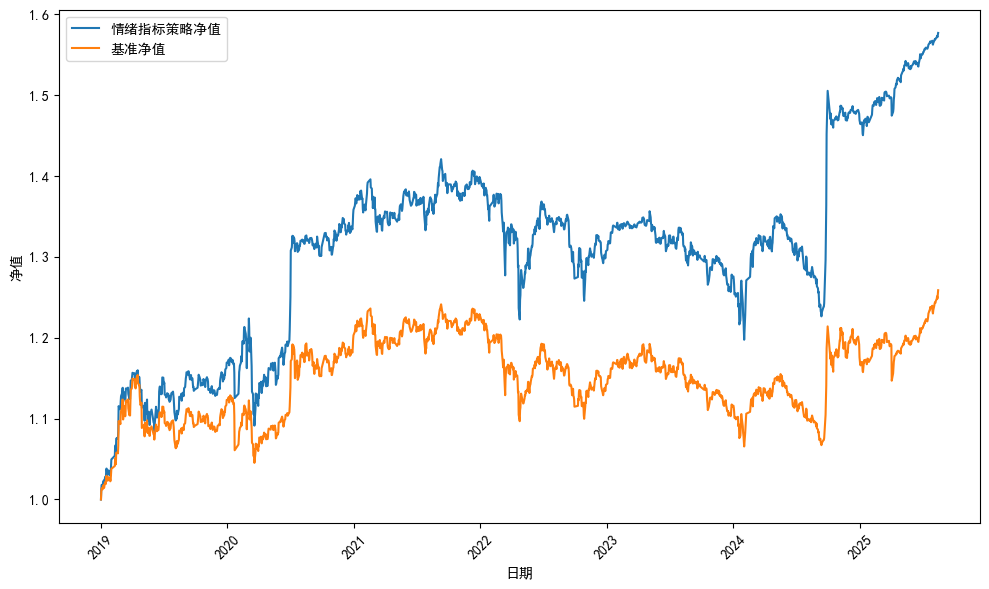

In [67]:
# 6. Plot NAV comparison
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['strat_nav'], label='情绪指标策略净值')
plt.plot(df['Date'], df['bench_nav'], label='基准净值')
# plt.title('Strategy vs Benchmark (2‑Day Confirmation)')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Step 4: identify non-neutral position change events
change_mask = df['Position'].diff().fillna(0) != 0
event_mask = change_mask & (df['Position'] != 0.5)
event_indices = df.index[event_mask]

# Step 5: compute forward horizon metrics
horizons = [5, 10, 20, 60]
records = []
for h in horizons:
    cum_returns = []
    for idx in event_indices:
        if idx + h < len(df):
            cum = (1 + df.loc[idx+1:idx+h, 'excess_ret']).prod() - 1
            cum_returns.append(cum)
    cum_returns = np.array(cum_returns)
    win_rate = (cum_returns > 0).mean() if len(cum_returns) else np.nan
    avg_ret = cum_returns.mean() if len(cum_returns) else np.nan
    records.append({'Horizon': f'T+{h}', 'Win Rate': win_rate, 'Avg Excess Return': avg_ret})

result_df = pd.DataFrame(records).set_index('Horizon')
result_df

,Win Rate,Avg Excess Return
Horizon,,
T+5,0.594595,0.001655
T+10,0.621622,0.003168
T+20,0.666667,0.005673
T+60,0.828571,0.017586


In [20]:
# 5. Excess performance metrics
total_excess = df['excess_nav'].iloc[-1] - 1
ann_excess = df['excess_nav'].iloc[-1] ** (252 / len(df)) - 1
max_dd_excess = (df['excess_nav'] / df['excess_nav'].cummax() - 1).min()

metrics = pd.DataFrame({
    'Total Excess Return': [total_excess],
    'Annual Excess Return': [ann_excess],
    'Excess Max Drawdown': [max_dd_excess]
}, index = ['超额收益'])
metrics

,Total Excess Return,Annual Excess Return,Excess Max Drawdown
超额收益,0.321651,0.045192,-0.024537


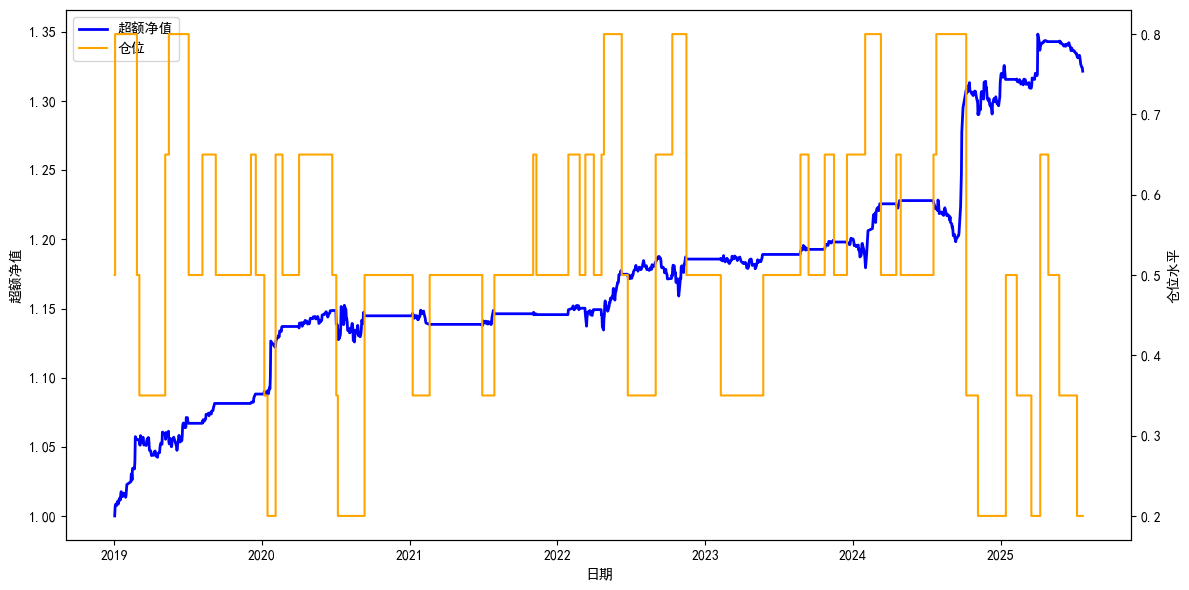

In [21]:
# 6. Plot excess NAV and position
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df['Date'], df['excess_nav'], color='blue', label='超额净值', linewidth=2)
ax1.set_ylabel('超额净值')
ax1.set_xlabel('日期')

ax2 = ax1.twinx()
ax2.step(df['Date'], df['Position'], where='post', color='orange', label='仓位', linewidth=1.5)
ax2.set_ylabel('仓位水平')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# plt.title('Excess NAV & Position Signal (2-day Confirmation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
